In [1]:
import numpy as np
import pandas as pd
import scanpy.api as sc
import anndata
import time
import wget
from datetime import timedelta
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures
sc.logging.print_versions()

/Users/iwes/anaconda3/envs/tf/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


scanpy==1.2.2+166.g6c1daba anndata==0.6.9 numpy==1.14.2 scipy==1.0.1 pandas==0.22.0 scikit-learn==0.19.1 statsmodels==0.8.0 python-igraph==0.7.1 louvain==0.6.1 


In [7]:
train_path = "../data/pancreas.h5ad"
if os.path.isfile(train_path):
    adata = sc.read(train_path)
else:
    train_url = "https://www.dropbox.com/s/zvmt8oxhfksumw2/pancreas.h5ad?dl=1"
    t_dl = wget.download(train_url, train_path)
    adata = sc.read(train_path)
adata = anndata.AnnData(X=np.expm1(adata.raw.X), var=adata.raw.var, obs=adata.obs)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
filter_result = sc.pp.filter_genes_dispersion(
    adata.X, min_mean=0.0125, max_mean=2.5, min_disp=0.7)
adata = adata[:, filter_result.gene_subset]
sc.pp.log1p(adata)

In [8]:
%load_ext rpy2.ipython

In [13]:
%%R

if (!('scran' %in% rownames(installed.packages())))
{
    source("https://bioconductor.org/biocLite.R")
    biocLite("scran")
}

In [9]:
df1 = pd.DataFrame(data=adata[adata.obs['sample']=='Baron'].X.todense().transpose(),
                  index=adata[adata.obs['sample']=='Baron'].var_names,
                  columns=adata[adata.obs['sample']=='Baron'].obs_names)

df2 = pd.DataFrame(data=adata[adata.obs['sample']=='Muraro'].X.todense().transpose(),
                  index=adata[adata.obs['sample']=='Muraro'].var_names,
                  columns=adata[adata.obs['sample']=='Muraro'].obs_names)

df3 = pd.DataFrame(data=adata[adata.obs['sample']=='Segerstolpe'].X.todense().transpose(),
                  index=adata[adata.obs['sample']=='Segerstolpe'].var_names,
                  columns=adata[adata.obs['sample']=='Segerstolpe'].obs_names)

df4 = pd.DataFrame(data=adata[adata.obs['sample']=='Wang'].X.todense().transpose(),
                  index=adata[adata.obs['sample']=='Wang'].var_names,
                  columns=adata[adata.obs['sample']=='Wang'].obs_names)

In [10]:
%%R -i df1 -i df2 -i df3 -i df4 -o odf1 -o odf2 -o odf3 -o odf4

suppressMessages(library(scran))

t1 = Sys.time()
mnncount = mnnCorrect(data.matrix(df1), data.matrix(df2), data.matrix(df3), data.matrix(df4), 
                      BPPARAM=MulticoreParam(detectCores()))
t2 = Sys.time()
print(t2-t1)

odf1 = data.frame(mnncount$corrected[[1]])
odf2 = data.frame(mnncount$corrected[[2]])
odf3 = data.frame(mnncount$corrected[[3]])
odf4 = data.frame(mnncount$corrected[[4]])

Time difference of 14.97376 mins


In [27]:
sc.set_figure_params(frameon=False)


Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:08.65) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:13.27) --> added
    'X_umap', UMAP coordinates (adata.obsm)
saving figure to file ./figures/umapmnn_correct.pdf


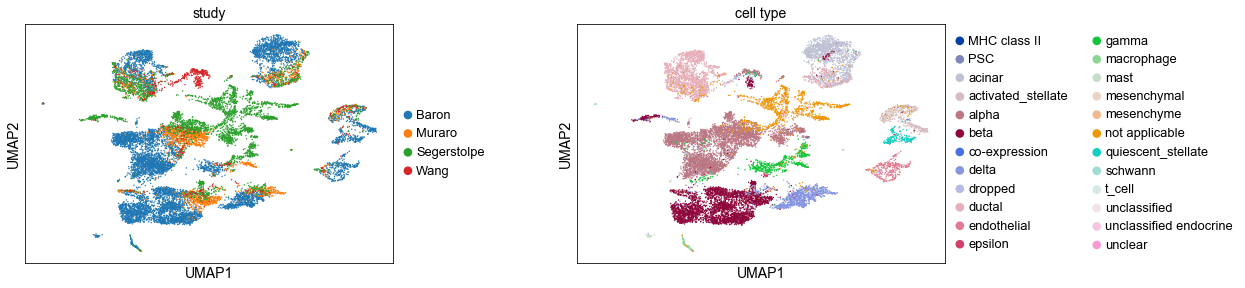

In [11]:
adata_mnncorrect = adata.copy()
adata_mnncorrect.X = np.concatenate((odf1.values.T, odf2.values.T, odf3.values.T, odf4.values.T))
sc.pp.scale(adata_mnncorrect, max_value=10)
sc.tl.pca(adata_mnncorrect)
adata_mnncorrect.obsm['X_pca'] *= -1 
sc.pp.neighbors(adata_mnncorrect)
sc.tl.umap(adata_mnncorrect)
adata_mnncorrect.obs["study"] = adata_mnncorrect.obs["sample"]
adata_mnncorrect.obs["cell type"] = adata_mnncorrect.obs["celltype"]
sc.pl.umap(adata_mnncorrect, color=['study','cell type'],save="mnn_correct.pdf")

In [2]:
import sklearn as sk 

In [9]:
sc.tl.pca(adata_mnncorrect, svd_solver='arpack')
X = adata_mnncorrect.obsm["X_pca"]
labels = adata_mnncorrect.obs["batch"].tolist()
print(f"  average silhouette_score for MNN :{sk.metrics.silhouette_score(X,labels)}")

  average silhouette_score for MNN :0.008741154335439205
